In [17]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [12]:
def calculate_ece(confidences, accuracies, n_bins=10) -> float:
    """
    Calculate the expected calibration error (ECE) given a list of confidence scores (0-1) and accuracy scores (0 or 1).
    """
    confidences = torch.tensor(list(confidences))
    accuracies = torch.tensor(list(accuracies))
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = torch.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculated |confidence - accuracy| in each bin
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()
        if prop_in_bin.item() > 0:
            accuracy_in_bin = accuracies[in_bin].float().mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece.item()

def stratified_sample(df, sample_frac=0.2):
    # Step 1: Stratified sampling
    stratified_df, _ = train_test_split(
        df, 
        train_size=sample_frac, 
        stratify=df['category']
    )
    return stratified_df

In [29]:
def get_ece(results_df, confidence_mode):
    category_sample_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    ece = {size : [] for size in category_sample_sizes}
    repeat = 50
    for size in category_sample_sizes:
        for _ in range(repeat):
            ss = stratified_sample(results_df, size)
            acc = (ss["extracted_answer"] == ss["correct_answer"]) * 1
            conf = ss[confidence_mode].tolist()
            ece[size].append(calculate_ece(conf, acc))
    return ece

def get_auroc(results_df, confidence_mode):
    category_sample_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    ece = {size : [] for size in category_sample_sizes}
    repeat = 50
    for size in category_sample_sizes:
        for _ in range(repeat):
            ss = stratified_sample(results_df, size)
            acc = (ss["extracted_answer"] == ss["correct_answer"]) * 1
            conf = ss[confidence_mode].tolist()
            ece[size].append(roc_auc_score(acc, conf))
    return ece

# Results

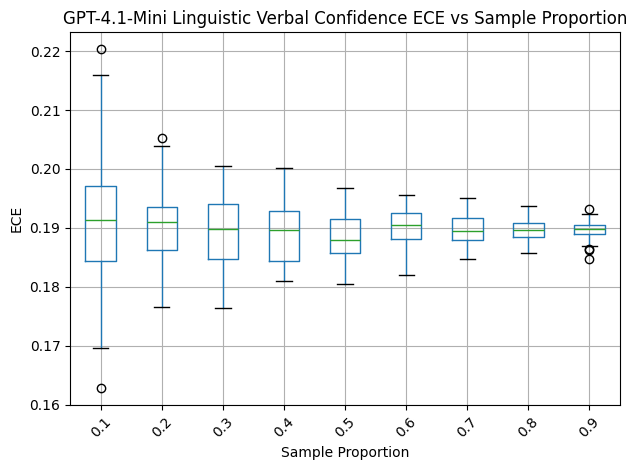

In [30]:
fig = pd.DataFrame(get_ece(pd.read_csv("../results/mmlu_pro_gpt-4.1-mini_eval_all_None.csv"), "verbal_linguistic_confidence")).boxplot()
plt.title("GPT-4.1-Mini Linguistic Verbal Confidence ECE vs Sample Proportion")
plt.xticks(rotation=45)
plt.xlabel("Sample Proportion")
plt.ylabel("ECE")
plt.tight_layout()
plt.show()

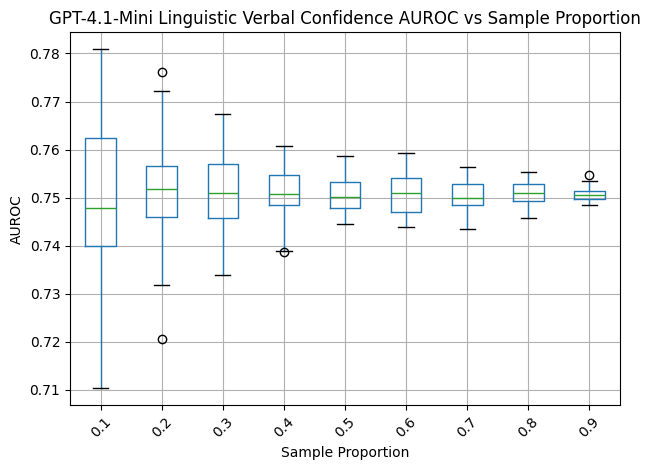

In [31]:
fig = pd.DataFrame(get_auroc(pd.read_csv("../results/mmlu_pro_gpt-4.1-mini_eval_all_None.csv"), "verbal_linguistic_confidence")).boxplot()
plt.title("GPT-4.1-Mini Linguistic Verbal Confidence AUROC vs Sample Proportion")
plt.xticks(rotation=45)
plt.xlabel("Sample Proportion")
plt.ylabel("AUROC")
plt.tight_layout()
plt.show()

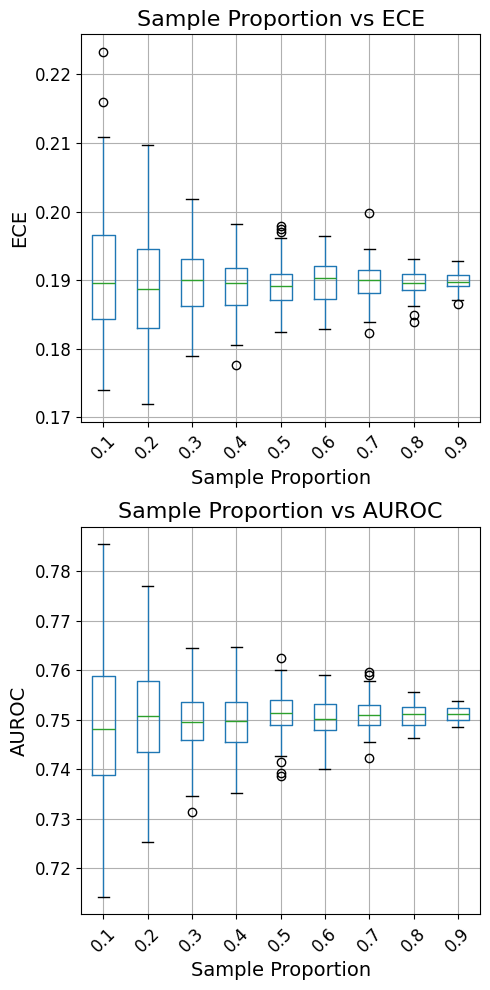

In [ ]:
# Load data
df = pd.read_csv("../results/mmlu_pro_gpt-4.1-mini_eval_all_None.csv")

# Compute metrics
ece_df = pd.DataFrame(get_ece(df, "verbal_linguistic_confidence"))
auroc_df = pd.DataFrame(get_auroc(df, "verbal_linguistic_confidence"))

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Overall title
# fig.suptitle("GPT-4.1-Mini Linguistic Verbal Confidence Metrics vs Sample Proportions", fontsize=20, fontweight='bold')

# Plot ECE boxplot
ece_df.boxplot(ax=axes[0])
axes[0].set_title("Sample Proportion vs ECE", fontsize=16)
axes[0].set_xlabel("Sample Proportion", fontsize=14)
axes[0].set_ylabel("ECE", fontsize=14)
axes[0].tick_params(axis='x', rotation=45, labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# Plot AUROC boxplot
auroc_df.boxplot(ax=axes[1])
axes[1].set_title("Sample Proportion vs AUROC", fontsize=16)
axes[1].set_xlabel("Sample Proportion", fontsize=14)
axes[1].set_ylabel("AUROC", fontsize=14)
axes[1].tick_params(axis='x', rotation=45, labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)

# Adjust layout
plt.tight_layout()
plt.savefig("../plots/mmlu_pro_subsets.pdf", dpi=300)
plt.show()
